In [1]:
# Предсказание
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Предобработка
from PIL import Image
from numpy import asarray
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



# 1. Поработаем с данными

- 1.1 Загрузить датасет с гугл диска
- 1.2 Конвертировать изображения в формат для pyTorch
- 1.3.1 Поделить выборку на validation и train
- 1.3.2 Создать подходящий для обучения data_loader 


In [2]:
COLAB = True

In [3]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/lizaalert /mydrive
!ls /mydrive

backup	data_without_videos  lizaalert	razm.csv


In [5]:
print("Loading CSV...")
liza_alert_data = pd.read_csv("/mydrive/razm.csv" if COLAB else "TODO:SPECIFY", encoding="UTF-8")
liza_alert_data.head()

Loading CSV...


,Названия,Время суток,Время года,Местность,Авиа,Автомобили,БПЛА,Водолаз,Кинолог,Кони,Объятия,Шерп
0,20220116_121426_00306.jpg,0,1,0,0,1,1,0,0,0,0,0
1,Шерп_00410.jpg,1,3,0,0,0,0,0,0,0,0,1
2,IMG_3374_00784.jpg,1,0,0,0,0,0,0,0,0,0,0
3,Закат_00006.jpg,3,3,0,0,0,0,0,0,0,0,0
4,Вертолет_01563.jpg,1,3,0,1,0,0,0,0,0,0,0


In [6]:
# Обнаружилось, что в датасете есть непригодные к обучению картинки (непонятного формата)
liza_alert_data[~liza_alert_data["Названия"].str.contains('.jpg',case=False)].head()
print("Процент плохих картинок: " + str(liza_alert_data[~liza_alert_data["Названия"].str.contains('.jpg',case=False)].shape[0]/liza_alert_data.shape[0] * 100) + '%')


Процент плохих картинок: 0.8745282150418853%


In [7]:
# Уберем непригодные к обучению картинки, поскольку они составляют незначительную часть датасета
liza_alert_data = liza_alert_data[liza_alert_data["Названия"].str.contains('.jpg',case=False)]

In [8]:
# Уберем лишние картинки
import os
liza_alert_data = liza_alert_data[[os.path.isfile('/mydrive/data_without_videos/' + i) for i in liza_alert_data['Названия']]]

In [9]:
liza_alert_data.head()

,Названия,Время суток,Время года,Местность,Авиа,Автомобили,БПЛА,Водолаз,Кинолог,Кони,Объятия,Шерп
3,Закат_00006.jpg,3,3,0,0,0,0,0,0,0,0,0
14,"ночь, осень_00228.jpg",2,4,2,0,1,0,0,0,0,0,0
15,Кинологи_3030060.jpg,1,4,0,0,0,0,0,1,0,0,0
21,DSC_4155.jpg,1,1,1,0,0,0,0,0,0,0,1
23,Водолазы1_00900.jpg,1,0,0,0,0,0,1,0,0,0,0


In [10]:
# Проверим на NaN
liza_alert_data.isnull().any()

Названия       False
Время суток    False
Время года     False
Местность      False
Авиа           False
Автомобили     False
БПЛА           False
Водолаз        False
Кинолог        False
Кони           False
Объятия        False
Шерп           False
dtype: bool

Сейчас датасет почти в готовом состоянии - но осталось:

- Заменить названия картинок на сами картинки
- Применить one-hot encoding для времени суток \ года как для категориальных признаков.

# One-hot encoding? - Неее
Было выявлено три категориальных признака:
- Время суток
- Время года
- Местность

Мы раздробили задачу на множество подзадач многоклассовой классификации - поэтому категориальные признаки, собранные в одном месте это лучшая подмога нам, поскольку мыслительный процесс нейросети касательно дня \ ночи будет проходить в одном месте, и следственно обучаться проще.


In [11]:
# # Заменим время суток на названия
# def numToDayTime(num):
#   if num == 0:
#     return 'NoDayTime'
#   if num == 1:
#     return 'День'
#   if num == 2:
#     return 'Ночь'
#   if num == 3:
#     return 'Рассвет/закат'
# transform = transforms.ToTensor()
# liza_alert_data['Время суток'] = liza_alert_data['Время суток'].map(numToDayTime)
# liza_alert_data.head()

In [12]:
# # Заменим время года на названия
# def numToYearTime(num):
#   if num == 0:
#     return 'NoYearTime'
#   if num == 1:
#     return 'Зима'
#   if num == 2:
#     return 'Весна'
#   if num == 3:
#     return 'Лето'
#   if num == 4:
#     return 'Осень'
# transform = transforms.ToTensor()
# liza_alert_data['Время года'] = liza_alert_data['Время года'].map(numToYearTime)
# liza_alert_data.head()

In [13]:
# # Заменим местность на названия
# def numToPlace(num):
#   if num == 0:
#     return 'NoPlace'
#   if num == 1:
#     return 'Лес'
#   if num == 2:
#     return 'Город'
# transform = transforms.ToTensor()
# liza_alert_data['Местность'] = liza_alert_data['Местность'].map(numToPlace)
# liza_alert_data.head()

In [14]:
# # One-hot encoding 
# dummy1 = pd.get_dummies(liza_alert_data['Время суток'], drop_first=True)
# dummy1.head()

In [15]:
# # One-hot encoding
# dummy2 = pd.get_dummies(liza_alert_data['Время года'], drop_first=True)
# dummy2.head()

In [16]:
# # One-hot encoding
# dummy3 = pd.get_dummies(liza_alert_data['Местность'], drop_first=True)
# dummy3.head()

In [17]:
# liza_alert_data = pd.concat([liza_alert_data, dummy1], axis=1).drop('Время суток', axis=1)
# liza_alert_data = pd.concat([liza_alert_data, dummy2], axis=1).drop('Время года', axis=1)
# liza_alert_data = pd.concat([liza_alert_data, dummy3], axis=1).drop('Местность', axis=1)

# liza_alert_data.head()

In [18]:
train_data = liza_alert_data

In [19]:
train_data.head()

,Названия,Время суток,Время года,Местность,Авиа,Автомобили,БПЛА,Водолаз,Кинолог,Кони,Объятия,Шерп
3,Закат_00006.jpg,3,3,0,0,0,0,0,0,0,0,0
14,"ночь, осень_00228.jpg",2,4,2,0,1,0,0,0,0,0,0
15,Кинологи_3030060.jpg,1,4,0,0,0,0,0,1,0,0,0
21,DSC_4155.jpg,1,1,1,0,0,0,0,0,0,0,1
23,Водолазы1_00900.jpg,1,0,0,0,0,0,1,0,0,0,0


# Пишем кастомный датасет

In [20]:
# Напишем кастомный датасет для pyTorch

from torch.utils.data import Dataset, DataLoader
import cv2
import os
class LizaAlertDataset(Dataset):
    def __init__(self, pandasFrame, transform, basedir, part):
        # initialize the arrays to store the ground truth labels and paths to the images
        self.image_paths = []
        # self.avia = []
        # self.color_labels = []
        # self.gender_labels = []
        # self.article_labels = []

        self.image_paths = pandasFrame['Названия'].values
        self.images = []

        self.label_avia = pandasFrame['Авиа'].values
        self.label_auto = pandasFrame['Автомобили'].values
        self.label_bpla = pandasFrame['БПЛА'].values
        self.label_diver = pandasFrame['Водолаз'].values
        self.label_cynologist = pandasFrame['Кинолог'].values
        self.label_horses = pandasFrame['Кони'].values
        self.label_hugs = pandasFrame['Объятия'].values
        self.label_sherp = pandasFrame['Шерп'].values
        self.label_timeday = pandasFrame['Время суток'].values
        self.label_timeyear = pandasFrame['Время года'].values        
        self.label_place = pandasFrame['Местность'].values

        self.transform = transform
        self.basedir = basedir



        # Load self.images
        self.part = part
        n_images = 0
        for img_path in self.image_paths:
           img = Image.open(self.basedir + '/' + img_path)
           if self.transform:
             img = self.transform(img)
           self.images.append(img)
           n_images += 1
           if (n_images % 50 == 0):
              print(f"{n_images} from {len(self.image_paths)/(1/part)}")
           if (n_images > len(self.image_paths)/(1/part)):
             print(str(n_images) + " has been loaded")
             break
       

        self.classes = [
          'label_avia',
          'label_auto',
          'label_bpla',
          'label_diver',
          'label_cynologist',
          'label_horses',
          'label_hugs',
          'label_sherp',
          'label_timeday',
          'label_timeyear',
          'label_place',
        ]



    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        dict_data = {
            'image': self.images[idx],
            'labels':{
                'label_avia': self.label_avia[idx],
                'label_auto': self.label_auto[idx],
                'label_bpla': self.label_bpla[idx],
                'label_diver': self.label_diver[idx],
                'label_cynologist': self.label_cynologist[idx],
                'label_horses': self.label_horses[idx],
                'label_hugs': self.label_hugs[idx],
                'label_sherp': self.label_sherp[idx],
                'label_timeday': self.label_timeday[idx],
                'label_timeyear': self.label_timeyear[idx],
                'label_place': self.label_place[idx],
            },
        }
      
        
        return dict_data

In [21]:
transform = transforms.Compose( 
            [
              transforms.Resize((256,256)),
              # transforms.RandomCrop(224),
              transforms.ToTensor()
            ]
        )
# Самый времязатратный процесс
lad = LizaAlertDataset(train_data, transform=transform, basedir='/mydrive/data_without_videos', part=0.65)
print(len(lad))

50 from 3013.4
100 from 3013.4
150 from 3013.4
200 from 3013.4
250 from 3013.4
300 from 3013.4
350 from 3013.4
400 from 3013.4
450 from 3013.4
500 from 3013.4
550 from 3013.4
600 from 3013.4
650 from 3013.4
700 from 3013.4
750 from 3013.4
800 from 3013.4
850 from 3013.4
900 from 3013.4
950 from 3013.4
1000 from 3013.4
1050 from 3013.4
1100 from 3013.4
1150 from 3013.4
1200 from 3013.4
1250 from 3013.4
1300 from 3013.4
1350 from 3013.4
1400 from 3013.4
1450 from 3013.4
1500 from 3013.4
1550 from 3013.4
1600 from 3013.4
1650 from 3013.4
1700 from 3013.4
1750 from 3013.4
1800 from 3013.4
1850 from 3013.4
1900 from 3013.4
1950 from 3013.4
2000 from 3013.4
2050 from 3013.4
2100 from 3013.4
2150 from 3013.4
2200 from 3013.4
2250 from 3013.4
2300 from 3013.4
2350 from 3013.4
2400 from 3013.4
2450 from 3013.4
2500 from 3013.4
2550 from 3013.4
2600 from 3013.4
2650 from 3013.4
2700 from 3013.4
2750 from 3013.4
2800 from 3013.4
2850 from 3013.4
2900 from 3013.4
2950 from 3013.4
3000 from 3013.4


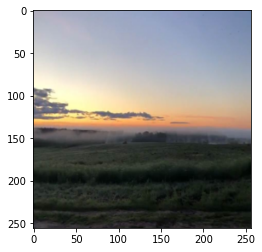

['label_avia: 0',
 'label_auto: 0',
 'label_bpla: 0',
 'label_diver: 0',
 'label_cynologist: 0',
 'label_horses: 0',
 'label_hugs: 0',
 'label_sherp: 0',
 'label_timeday: 3',
 'label_timeyear: 3',
 'label_place: 0']


In [22]:
import matplotlib.pyplot as plt
from pprint import pprint
idx = 0
plt.imshow(np.asarray(np.asarray(lad[idx]['image'].squeeze().permute(1,2,0))))
plt.show()
pprint([f'{k}: {v}' for k,v in lad[idx]['labels'].items()])

# Поделим данные на тест и валидацию, и загрузим в DataLoader'ы

In [23]:
batch_size = 128
max_epoch_number = 120
learning_rate = 1e-3
from torch.utils.data import DataLoader
training_data, test_data = torch.utils.data.random_split(lad, [int(2*len(lad)/4), int(2*len(lad)/4)], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))
print(len(test_loader))

12
12


In [24]:
sample = next(iter(train_loader))

In [25]:
print("Keys in our sample batch: {}".format(sample.keys()))
print("Size for the images in our sample batch: {}".format(sample['image'].shape))
print("Size for the target in our sample batch: {}".format(sample['labels']['label_timeday'].shape))
print("Targets for each batch in our sample: {}".format(sample['labels']['label_timeyear']))

Keys in our sample batch: dict_keys(['image', 'labels'])
Size for the images in our sample batch: torch.Size([128, 3, 256, 256])
Size for the target in our sample batch: torch.Size([128])
Targets for each batch in our sample: tensor([4, 0, 3, 4, 0, 0, 4, 4, 3, 3, 0, 3, 0, 2, 0, 0, 3, 0, 4, 0, 0, 0, 1, 3,
        1, 3, 0, 3, 4, 3, 0, 0, 4, 3, 3, 0, 4, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0,
        3, 0, 4, 0, 0, 4, 4, 3, 0, 0, 3, 3, 0, 3, 3, 3, 4, 3, 1, 2, 4, 0, 0, 0,
        3, 0, 4, 0, 2, 0, 0, 0, 3, 4, 4, 3, 2, 3, 4, 0, 1, 3, 0, 0, 0, 3, 0, 0,
        4, 4, 1, 1, 3, 3, 3, 0, 3, 3, 0, 3, 4, 3, 0, 3, 4, 2, 0, 0, 3, 0, 3, 0,
        0, 3, 3, 0, 4, 4, 0, 3])


# Наша модель - основанная на resnet34

In [26]:
class MultilabelClassifier(torch.nn.Module):
    def __init__(self, 
          n_avia=2, 
          n_auto=2,                
          n_bpla=2,
          n_diver=2,
          n_cynologist=2,
          n_horses=2,
          n_hugs=2,
          n_sherp=2,
          n_timeOfTheDay=4,
          n_timeOfTheYear=5,
          n_place=3,       
        ):
        super().__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        self.model_wo_fc = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))



        self.avia = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_avia),
            # torch.nn.Softmax()
        )
        self.auto = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_auto),
            # torch.nn.Softmax()
        )

        self.bpla = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_bpla),
            # torch.nn.Softmax()
        )
        self.diver = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_diver),
            # torch.nn.Softmax()
        )
        self.cynologist = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_cynologist),
            # torch.nn.Softmax()
        )
        self.horses = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_horses),
            # torch.nn.Softmax()
        )
        self.hugs = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_hugs),
            # torch.nn.Softmax()
        )
        self.sherp = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_sherp),
            # torch.nn.Softmax()
        )
        self.timeOfTheDay = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_timeOfTheDay),
            # torch.nn.Softmax()
        )
        self.timeOfTheYear = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_timeOfTheYear),
            # torch.nn.Softmax()
        )
        self.place = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=n_place),
            # torch.nn.Softmax()
        )


    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
          'avia': self.avia(x),           
          'auto': self.auto(x),                
          'bpla': self.bpla(x),
          'diver': self.diver(x),
          'cynologist': self.cynologist(x),
          'horses': self.horses(x),
          'hugs': self.hugs(x),
          'sherp': self.sherp(x),
          'timeday': self.timeOfTheDay(x),
          'timeyear': self.timeOfTheYear(x),
          'place': self.place(x),       
        }


Проверим работоспособность (на всякий случай)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

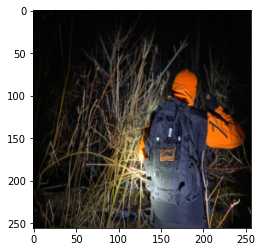

['label_avia: 0',
 'label_auto: 0',
 'label_bpla: 0',
 'label_diver: 0',
 'label_cynologist: 0',
 'label_horses: 0',
 'label_hugs: 0',
 'label_sherp: 0',
 'label_timeday: 2',
 'label_timeyear: 2',
 'label_place: 1']


In [27]:
model = MultilabelClassifier()

sample = next(iter(train_loader)) 

import matplotlib.pyplot as plt
from pprint import pprint
idx = 0
plt.imshow(np.asarray(np.asarray(sample['image'][0].squeeze().permute(1,2,0))))
plt.show()
pprint([f'{k}: {v.cpu().numpy()[0]}' for k,v in sample['labels'].items()])

In [28]:
pred = model((sample['image'][:1]))

In [29]:
def predToRes(pred):
  res = {}
  for k,v in pred.items():
    res[k] = v.argmax().item()
  return res

pprint(predToRes(pred))

{'auto': 0,
 'avia': 0,
 'bpla': 0,
 'cynologist': 0,
 'diver': 1,
 'horses': 1,
 'hugs': 0,
 'place': 2,
 'sherp': 1,
 'timeday': 2,
 'timeyear': 2}


# Можно приступать к обучению!

In [30]:
# Переведём в cuda...
if torch.cuda.is_available():
    model.cuda()
model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

### Цикл обучения

In [31]:
# from sklearn.metrics import *
# def calculate_metrics(pred, target, threshold=0.5):
#     pred = np.array(pred > threshold, dtype=float)
#     return {
#             # 'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
#             # 'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
#             # 'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
#             'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
#             'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
#             'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
#             # 'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
#             # 'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
#             # 'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
#             }
    # from sklearn.metrics import f1_score   


In [74]:
def criterion(loss_func,outputs,pictures):
  losses = 0
  for i, key in enumerate(outputs):
    losses += loss_func(outputs[key], pictures['labels'][f'label_{key}'].to(device))
  return losses

def training(model,device,lr_rate,epochs,train_loader):
  num_epochs = epochs
  losses = []
  checkpoint_losses = []
  stat = []
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
  n_total_steps = len(train_loader)

  loss_func = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
     for i, pictures in enumerate(train_loader):
        images = pictures['image'].to(device)
        pictures = pictures

        outputs = model(images)

        loss = criterion(loss_func,outputs, pictures)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % (int(n_total_steps/1)) == 0:
            checkpoint_loss = torch.tensor(losses).mean().item()
            checkpoint_losses.append(checkpoint_loss)
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {checkpoint_loss:.4f}')
            
            # # Calc Metric
            # model.eval()
            # with torch.no_grad():
            #     # F1 append
            #     corpse = next(iter(test_loader))
            #     _f1_score = f1_score(np.array(list(corpse['labels'].values())), np.array(list(predToRes(model(corpse['image'])).values())))
            #     stat.append(_f1_score)
            # model.train()



  return checkpoint_losses

checkpoint_losses_2 = training(model, device, 0.0001, 100, train_loader)

Epoch [1/100], Step [12/12], Loss: 0.1864
Epoch [2/100], Step [12/12], Loss: 0.1237
Epoch [3/100], Step [12/12], Loss: 0.0875
Epoch [4/100], Step [12/12], Loss: 0.0674
Epoch [5/100], Step [12/12], Loss: 0.0550
Epoch [6/100], Step [12/12], Loss: 0.0468
Epoch [7/100], Step [12/12], Loss: 0.0405
Epoch [8/100], Step [12/12], Loss: 0.0357
Epoch [9/100], Step [12/12], Loss: 0.0321
Epoch [10/100], Step [12/12], Loss: 0.0291
Epoch [11/100], Step [12/12], Loss: 0.0267
Epoch [12/100], Step [12/12], Loss: 0.0246
Epoch [13/100], Step [12/12], Loss: 0.0229
Epoch [14/100], Step [12/12], Loss: 0.0215
Epoch [15/100], Step [12/12], Loss: 0.0202
Epoch [16/100], Step [12/12], Loss: 0.0191
Epoch [17/100], Step [12/12], Loss: 0.0181
Epoch [18/100], Step [12/12], Loss: 0.0172
Epoch [19/100], Step [12/12], Loss: 0.0165
Epoch [20/100], Step [12/12], Loss: 0.0158
Epoch [21/100], Step [12/12], Loss: 0.0151
Epoch [22/100], Step [12/12], Loss: 0.0146
Epoch [23/100], Step [12/12], Loss: 0.0140
Epoch [24/100], Step

[3.1906940937042236, 2.201087713241577, 1.6846648454666138, 1.3614338636398315, 1.1385949850082397, 0.9766989946365356, 0.8556922674179077, 0.7615925669670105, 0.6870082020759583, 0.6261078715324402, 0.5751165151596069, 0.5322057008743286, 0.49531546235084534, 0.4632260501384735, 0.43501782417297363, 0.4103526771068573, 0.38835471868515015, 0.3686767816543579, 0.3508414924144745, 0.3347245454788208, 0.3201213479042053, 0.3067944645881653, 0.29452601075172424, 0.2833673059940338, 0.2730288803577423, 0.26335588097572327, 0.25432491302490234, 0.24595391750335693, 0.23810888826847076, 0.2307257503271103, 0.2238749861717224, 0.21738672256469727, 0.21126601099967957, 0.2055366337299347, 0.2000504434108734, 0.194928377866745, 0.1900651901960373, 0.18537317216396332, 0.18092131614685059, 0.17668472230434418, 0.17268270254135132, 0.16887395083904266, 0.16523979604244232, 0.16177256405353546, 0.15848171710968018, 0.15528789162635803, 0.1522226482629776, 0.14925289154052734, 0.14640742540359497, 

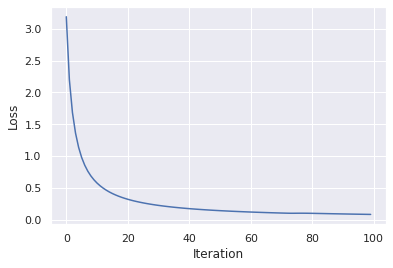

In [90]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
print(checkpoint_losses)
plt.plot(checkpoint_losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

[0.18644875288009644, 0.1237148568034172, 0.08750271052122116, 0.06742628663778305, 0.05502510443329811, 0.04679609462618828, 0.04051409289240837, 0.03573964163661003, 0.03210160508751869, 0.02909512259066105, 0.026654928922653198, 0.02464325539767742, 0.02291221357882023, 0.021492214873433113, 0.020196717232465744, 0.01906823180615902, 0.018096480518579483, 0.01721450313925743, 0.016462888568639755, 0.01576780341565609, 0.01512521505355835, 0.014556660316884518, 0.014028791338205338, 0.013552535325288773, 0.013120207004249096, 0.012706590816378593, 0.012342785485088825, 0.011983465403318405, 0.011645292863249779, 0.011337464675307274, 0.011039053089916706, 0.010758358985185623, 0.010514847002923489, 0.010261704213917255, 0.010030380450189114, 0.009820287115871906, 0.009612618014216423, 0.009415066801011562, 0.009228825569152832, 0.009051742032170296, 0.008882795460522175, 0.008722569793462753, 0.008570240810513496, 0.008426638320088387, 0.008281072601675987, 0.008156650699675083, 0.00

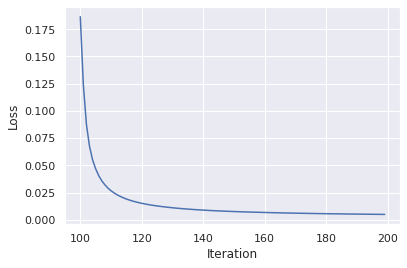

In [91]:
import matplotlib.pyplot as plt
print(checkpoint_losses_2, )
plt.plot(range(100,200), checkpoint_losses_2,)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

[0.18644875288009644, 0.1237148568034172, 0.08750271052122116, 0.06742628663778305, 0.05502510443329811, 0.04679609462618828, 0.04051409289240837, 0.03573964163661003, 0.03210160508751869, 0.02909512259066105, 0.026654928922653198, 0.02464325539767742, 0.02291221357882023, 0.021492214873433113, 0.020196717232465744, 0.01906823180615902, 0.018096480518579483, 0.01721450313925743, 0.016462888568639755, 0.01576780341565609, 0.01512521505355835, 0.014556660316884518, 0.014028791338205338, 0.013552535325288773, 0.013120207004249096, 0.012706590816378593, 0.012342785485088825, 0.011983465403318405, 0.011645292863249779, 0.011337464675307274, 0.011039053089916706, 0.010758358985185623, 0.010514847002923489, 0.010261704213917255, 0.010030380450189114, 0.009820287115871906, 0.009612618014216423, 0.009415066801011562, 0.009228825569152832, 0.009051742032170296, 0.008882795460522175, 0.008722569793462753, 0.008570240810513496, 0.008426638320088387, 0.008281072601675987, 0.008156650699675083, 0.00

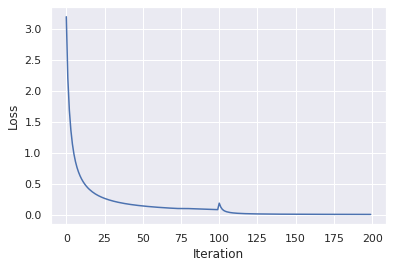

In [94]:
 import matplotlib.pyplot as plt
print(checkpoint_losses_2, )
plt.plot(range(0,200), checkpoint_losses + checkpoint_losses_2,)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()
 

In [ ]:
# import matplotlib.pyplot as plt
# print(stat)
# plt.plot(stat)
# plt.ylabel('F1')
# plt.show()

In [76]:
torch.save(model, '/mydrive/backup/model_last_gpu__lastlast.pth')

In [ ]:
assert False

# 3. Протестировать модель ручками!


In [138]:
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
      return name
filename = upload()

Saving vp9j4bsaKNE.jpg to vp9j4bsaKNE.jpg
saved file vp9j4bsaKNE.jpg


In [67]:
# model = torch.load('/mydrive/backup/model_last.pth')
# torch.save(model, '/mydrive/backup/model_last_gpu.pth')

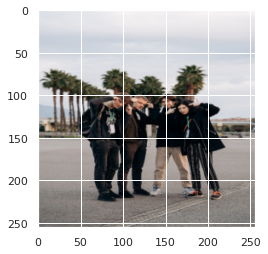

{'auto': 0,
 'avia': 0,
 'bpla': 0,
 'cynologist': 0,
 'diver': 0,
 'horses': 1,
 'hugs': 0,
 'place': 0,
 'sherp': 0,
 'timeday': 1,
 'timeyear': 1}


In [140]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
device
# model.load_state_dict(torch.load('/mydrive/backup/model_iter_2133_epoch_82.pth', map_location=device))
model.eval()

photo = transform(Image.open(filename))
plt.imshow(photo.permute(1,2,0))
plt.show()
if torch.cuda.is_available():
  photo = photo.to(device)
photo = photo.unsqueeze(0)

pred = model(photo)

pprint(predToRes(pred))



# (⊙_⊙) оно работает

# Метрики модели
48 часов без сна приводят к тому что методы из библиотеки применять не получается. Быстрее было написать свой F1. Так мы и сделали.

In [142]:
model.eval()
def evalu(model,device,test_loader, field):
  tp,fp,fn,tn=0,0,0,0
  outputs = 0
  for i, pictures in enumerate(test_loader):
        with torch.no_grad():
        
            images = pictures['image'].to(device)
            pictures = pictures

            outputs = model(images)
            outpootis = np.array([k.argmax().item() for k in outputs[field]])

            truth = pictures['labels'][f'label_{field}'].numpy()
            prediction = outpootis
            for i in range(0, len(prediction)):
              if truth[i] == prediction[i] and truth[i] == 1:
                tp+=1
              if truth[i] != prediction[i] and truth[i] == 1:
                fn+=1
              if truth[i] == prediction[i] and truth[i] == 0:
                tn+=1
              if truth[i] != prediction[i] and truth[i] == 0:
                fp+=1
            
            # for k in zip(list(outputs.values())):
            # break


  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  f1 = 2*tp / (2*tp + fp + fn)
  return f1

device=torch.device('cpu')
model = torch.load('/mydrive/backup/model_last_gpu__lastlast.pth')
model = model.to(device)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [148]:
#Last weights
device=torch.device('cpu')
model = torch.load('/mydrive/backup/model_last_gpu__lastlast.pth')
model = model.to(device)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
print(lad.classes)
f1_last = [
  evalu(model, device, test_loader, 'avia'),
  evalu(model, device, test_loader, 'auto'),
  evalu(model, device, test_loader, 'bpla'),
  evalu(model, device, test_loader, 'diver'),
  evalu(model, device, test_loader, 'cynologist'),
  evalu(model, device, test_loader, 'horses'),
  evalu(model, device, test_loader, 'hugs'),
  evalu(model, device, test_loader, 'sherp'),
]
print(f1_last)

['label_avia', 'label_auto', 'label_bpla', 'label_diver', 'label_cynologist', 'label_horses', 'label_hugs', 'label_sherp', 'label_timeday', 'label_timeyear', 'label_place']
[0.7692307692307693, 0.96, 0.8571428571428571, 0.9990281827016521, 0.9796839729119639, 0.9753694581280788, 0.9734513274336283, 0.989010989010989]


In [144]:
#F1 for 200 iterations
print('%.10f' % (sum(f1_last)/8))

0.9378646946


### Ура! Модель не переобучилась, чего мы очень боялись, и вышла довольно точной. Ура! Всё было не зря!



## Предсказание для приватного датасета